In [ ]:
!pip install "u8darts[torch-nolight]"

In [ ]:
! pip install pytorch-lightning
!pip install pyyaml==5.4.1

In [3]:
from darts import TimeSeries

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import Scaler

from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset

import warnings

warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [88]:
from darts.models.forecasting.transformer_model import TransformerModel

In [ ]:
TransformerModel

In [112]:
data = pd.read_csv('times.csv')

In [113]:
data

,Date_Time,Test_Time(s),Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),Environment_Temperature(C),Cell_Temperature(C)
0,2018-02-01 10:02:10.002962,10.002,1.0,0.000,2.940,0.000,0.000,0.000,0.000,15.163,15.375
1,2018-02-01 10:02:20.016433,20.016,1.0,0.000,2.941,0.000,0.000,0.000,0.000,15.148,15.437
2,2018-02-01 10:02:30.031429,30.031,1.0,0.000,2.941,0.000,0.000,0.000,0.000,15.087,15.375
3,2018-02-01 10:02:40.046426,40.046,1.0,0.000,2.941,0.000,0.000,0.000,0.000,15.240,15.375
4,2018-02-01 10:02:50.061462,50.061,1.0,0.000,2.941,0.000,0.000,0.000,0.000,15.087,15.375
...,...,...,...,...,...,...,...,...,...,...,...
65529,2018-05-13 07:29:24.144877,6611771.681,590.0,-1.100,3.175,1.029,0.256,3.475,0.822,14.990,16.429
65530,2018-05-13 07:31:24.152100,6611891.688,590.0,-1.100,3.168,1.029,0.293,3.475,0.939,14.744,16.413
65531,2018-05-13 07:33:24.162624,6612011.699,590.0,-1.099,3.162,1.029,0.330,3.475,1.055,14.713,16.382
65532,2018-05-13 07:35:24.175924,6612131.712,590.0,-1.100,3.157,1.029,0.366,3.475,1.171,14.790,16.383


In [16]:
data

,Test_Time(s),Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),Environment_Temperature(C),Cell_Temperature(C),idx,index_col
Date_Time,,,,,,,,,,,,
2018-02-01 10:02:10.002962,10.002,1.0,0.000,2.940,0.000,0.000,0.000,0.000,15.163,15.375,1,2018-02-01 10:02:10.002962
2018-02-01 10:02:20.016433,20.016,1.0,0.000,2.941,0.000,0.000,0.000,0.000,15.148,15.437,2,2018-02-01 10:02:20.016433
2018-02-01 10:02:30.031429,30.031,1.0,0.000,2.941,0.000,0.000,0.000,0.000,15.087,15.375,3,2018-02-01 10:02:30.031429
2018-02-01 10:02:40.046426,40.046,1.0,0.000,2.941,0.000,0.000,0.000,0.000,15.240,15.375,4,2018-02-01 10:02:40.046426
2018-02-01 10:02:50.061462,50.061,1.0,0.000,2.941,0.000,0.000,0.000,0.000,15.087,15.375,5,2018-02-01 10:02:50.061462
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-13 07:29:24.144877,6611771.681,590.0,-1.100,3.175,1.029,0.256,3.475,0.822,14.990,16.429,65530,2018-05-13 07:29:24.144877
2018-05-13 07:31:24.152100,6611891.688,590.0,-1.100,3.168,1.029,0.293,3.475,0.939,14.744,16.413,65531,2018-05-13 07:31:24.152100
2018-05-13 07:33:24.162624,6612011.699,590.0,-1.099,3.162,1.029,0.330,3.475,1.055,14.713,16.382,65532,2018-05-13 07:33:24.162624


In [114]:
values = data.columns.tolist()

In [115]:
values

['Date_Time',
 'Test_Time(s)',
 'Cycle_Index',
 'Current(A)',
 'Voltage(V)',
 'Charge_Capacity(Ah)',
 'Discharge_Capacity(Ah)',
 'Charge_Energy(Wh)',
 'Discharge_Energy(Wh)',
 'Environment_Temperature(C)',
 'Cell_Temperature(C)']

In [107]:
#data['Date_Time'] = pd.to_datetime(data['Date_Time'], format='%H%M%S%f').data.time
data['Date_Time'] =  pd.to_datetime(data['Date_Time'])


In [108]:
print(data['Date_Time'][0])

2018-02-01 10:02:10.002962


In [118]:
data['index']=data.index

In [116]:
data

,Date_Time,Test_Time(s),Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),Environment_Temperature(C),Cell_Temperature(C)
0,2018-02-01 10:02:10.002962,10.002,1.0,0.000,2.940,0.000,0.000,0.000,0.000,15.163,15.375
1,2018-02-01 10:02:20.016433,20.016,1.0,0.000,2.941,0.000,0.000,0.000,0.000,15.148,15.437
2,2018-02-01 10:02:30.031429,30.031,1.0,0.000,2.941,0.000,0.000,0.000,0.000,15.087,15.375
3,2018-02-01 10:02:40.046426,40.046,1.0,0.000,2.941,0.000,0.000,0.000,0.000,15.240,15.375
4,2018-02-01 10:02:50.061462,50.061,1.0,0.000,2.941,0.000,0.000,0.000,0.000,15.087,15.375
...,...,...,...,...,...,...,...,...,...,...,...
65529,2018-05-13 07:29:24.144877,6611771.681,590.0,-1.100,3.175,1.029,0.256,3.475,0.822,14.990,16.429
65530,2018-05-13 07:31:24.152100,6611891.688,590.0,-1.100,3.168,1.029,0.293,3.475,0.939,14.744,16.413
65531,2018-05-13 07:33:24.162624,6612011.699,590.0,-1.099,3.162,1.029,0.330,3.475,1.055,14.713,16.382
65532,2018-05-13 07:35:24.175924,6612131.712,590.0,-1.100,3.157,1.029,0.366,3.475,1.171,14.790,16.383


In [120]:
data['Date_Time'] = data['Date_Time'].astype(float)

ValueError: ignored

In [119]:
series = TimeSeries.from_dataframe(data, time_col='index',value_cols = values,fill_missing_dates=True)

ValueError: ignored

In [76]:
from datetime import datetime
time_data = "2018-05-02 15:43:00.246131"
 
# format the string in the given format :
# day/month/year hours/minutes/seconds-micro
# seconds
format_data = "%Y-%m-%d %H:%M:%S.%f"
 
# Using strptime with datetime we will format
# string into datetime
date = datetime.strptime(time_data, format_data)
# current date and time


timestamp = datetime.timestamp(date)

In [77]:
timestamp

1525275780.246131

In [82]:
len(data)

65534

In [84]:
train, val = series.split_after(60000)

In [85]:
val

<TimeSeries (DataArray) (index: 5533, component: 10, sample: 1)>
array([[[ 5.93009529e+06],
        [ 5.29000000e+02],
        [ 5.49000000e-01],
        ...,
        [ 0.00000000e+00],
        [ 1.48210000e+01],
        [ 1.61830000e+01]],

       [[ 5.93021532e+06],
        [ 5.29000000e+02],
        [ 5.49000000e-01],
        ...,
        [ 0.00000000e+00],
        [ 1.49130000e+01],
        [ 1.61220000e+01]],

       [[ 5.93033534e+06],
        [ 5.29000000e+02],
        [ 5.50000000e-01],
        ...,
...
        ...,
        [ 1.05500000e+00],
        [ 1.47130000e+01],
        [ 1.63820000e+01]],

       [[ 6.61213171e+06],
        [ 5.90000000e+02],
        [-1.10000000e+00],
        ...,
        [ 1.17100000e+00],
        [ 1.47900000e+01],
        [ 1.63830000e+01]],

       [[ 6.61225172e+06],
        [ 5.90000000e+02],
        [-1.09900000e+00],
        ...,
        [ 1.28600000e+00],
        [ 1.45900000e+01],
        [ 1.62590000e+01]]])
Coordinates:
  * index      (index) int64 60001 60002 60003 60004 ... 65530 65531 65532 65533
  * component  (component) object 'Test_Time(s)' ... 'Cell_Temperature(C)'
Dimensions without coordinates: sample

In [86]:
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

In [102]:
values

['Test_Time(s)',
 'Cycle_Index',
 'Current(A)',
 'Voltage(V)',
 'Charge_Capacity(Ah)',
 'Discharge_Capacity(Ah)',
 'Charge_Energy(Wh)',
 'Discharge_Energy(Wh)',
 'Environment_Temperature(C)',
 'Cell_Temperature(C)']

In [89]:
my_model = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=10,
    model_name="air_transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
)

In [90]:
my_model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [91]:
pred=my_model.predict(30)

Predicting: 1875it [00:00, ?it/s]

In [92]:
pred=scaler.inverse_transform(pred)

In [93]:
pred.to_csv('tmp.csv')

In [97]:
pred_df=pd.read_csv('tmp.csv')

In [94]:
real=val[:30]

In [95]:
real.to_csv('tmp1.csv')
real_df=pd.read_csv('tmp1.csv')

In [98]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(real_df[values],pred_df[values])

In [99]:
error

4006012471.447608

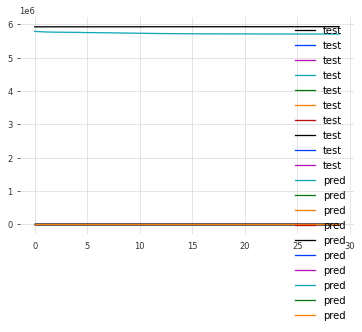

In [101]:
plt.plot(real_df[values], label='test')
plt.plot(pred_df[values], label='pred')
plt.legend()
plt.show()

In [1]:
!pip install tsai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 241 kB 34.5 MB/s 
     |████████████████████████████████| 197 kB 73.2 MB/s 
     |████████████████████████████████| 2.5 MB 64.2 MB/s 
     |████████████████████████████████| 59 kB 9.0 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
